# Chapter 7 - Unsupervised Learning

Import required Python packages

In [4]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline

Path set:

In [7]:
SP500_DATA_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\sp500_data.csv"
SP500_SECTORS_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\sp500_sectors.csv"
LOAN_DATA_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\loan_data.csv"
HOUSE_TASKS_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\housetasks.csv"


# Principal Component Analysis

# A Simple Example
In _Python_, we can use the scikit-learn implementation `sklearn.decomposition.PCA`:

In [19]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
oil_px = sp500_px[['XOM', 'CVX']]
print(oil_px.head())

                 XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272


In [23]:
pcs = PCA(n_components=2)
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print(loadings)

        XOM       CVX
0  0.664711  0.747101
1  0.747101 -0.664711


It is instructive to plot the principal components with the data. Here we create a visualization in _Python_:

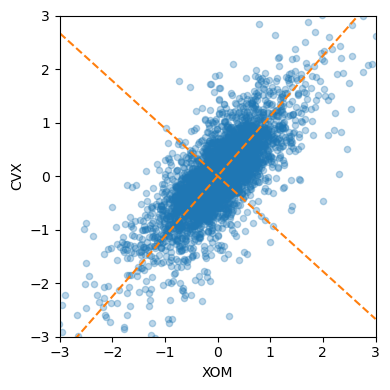

In [32]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return(x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4,4))
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax), 
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax), 
        '--', color='C1')


plt.tight_layout()
plt.show()

# Interpreting Principal Components

The following codes shows an example for a few top companies in the S&P 500. The information to create a loading plot from `scikit-learn` results is available in `explained_variance_`. Here, we convert it into a pandas data frame and use it to make a bar chart:

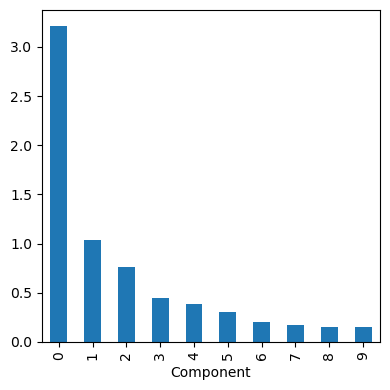

In [40]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
              'JPM', 'WFC', 'USB','AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4,4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

It can be especially revealing to plot the weights of the top principal components. Here is the code to create visualization in _Python_.

In [46]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], columns=top_sp.columns)
print(loadings)

       AAPL       AXP       COP      COST      CSCO       CVX        HD  \
0  0.300825  0.246332  0.261529  0.273634  0.064059  0.444490  0.207983   
1  0.505116  0.139426 -0.174212  0.416307  0.031939 -0.289373  0.278002   
2  0.786730 -0.135458  0.002367 -0.465862  0.007524 -0.082374 -0.166320   
3 -0.120586  0.061814 -0.206026  0.092596  0.003904 -0.577665  0.162814   
4 -0.111576  0.596666  0.005813 -0.555529  0.039860 -0.109016  0.185488   

       INTC       JPM      MSFT       SLB       TGT       USB       WFC  \
0  0.076956  0.196397  0.105012  0.481786  0.148833  0.116421  0.145684   
1  0.033898  0.040723  0.053954 -0.472494  0.228123  0.054796  0.047427   
2  0.003518 -0.062261 -0.016248  0.194822 -0.160833 -0.048976 -0.041932   
3 -0.001605  0.057687 -0.012558  0.680914  0.109895  0.016752  0.018614   
4  0.072047  0.385160  0.077135 -0.181332  0.055557  0.155440  0.216425   

        WMT       XOM  
0  0.122304  0.317952  
1  0.222889 -0.154192  
2 -0.175806 -0.090167  
3 

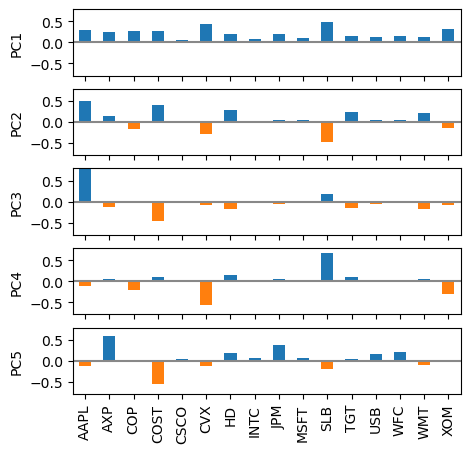

In [56]:
maxPC = 1.01 * np.max(np.max(np.abs(loadings.loc[0:5, :])))

f, axes = plt.subplots(5, 1, figsize=(5,5), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

# Correspondence Analysis

In _Python_, we can use the `prince` package, which implements correspondence analysis using the `scikit-lean` API:

In [66]:
# from adjustText import adjust_text

ModuleNotFoundError: No module named 'adjustText'

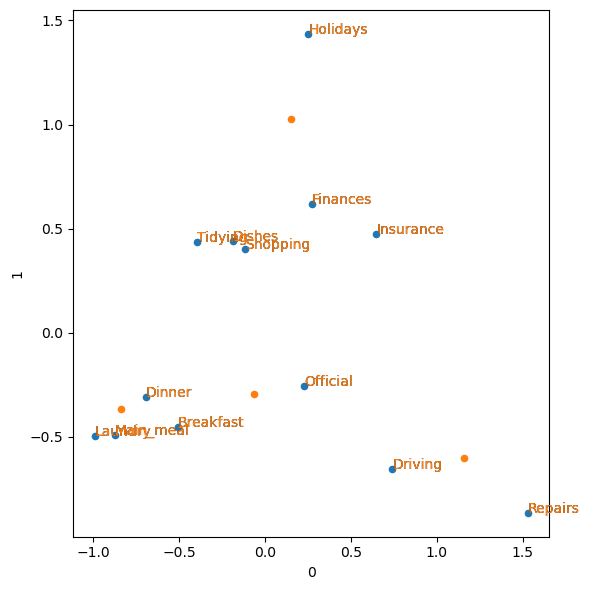

In [68]:
housetasks = pd.read_csv(HOUSE_TASKS_CSV, index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ax = ca.row_coordinates(housetasks).plot.scatter(x=0, y=1, figsize=(6,6))
ca.column_coordinates(housetasks).plot.scatter(x=0, y=1, ax=ax,c='C1')
texts = []
for idx, row in ca.row_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx))
for idx, row in ca.row_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx, color='C1'))
# adjust_text(texts, only_move={'points': 'y', 'texts': 'y'})
plt.tight_layout()
plt.show()